**1.  Super-resolution: Perform superresolution on the image shown in notebook to enhance its resolution by factor 2. Show a qualitative comparison of original and reconstructed image. (i.e display original image and the image you created side by side) **[3 Marks]****
**2. The above only helps us with a qualitative comparison. Let us now do a quantitative comparison. Compute the below given metrics:  **[1 Marks]**
    - RMSE on predicted v/s ground truth high resolution image
    - Peak SNR on predicted v/s ground truth high resolution image****

**Answer:** Using and Exploring OpenCV:

(1365, 2048, 3)


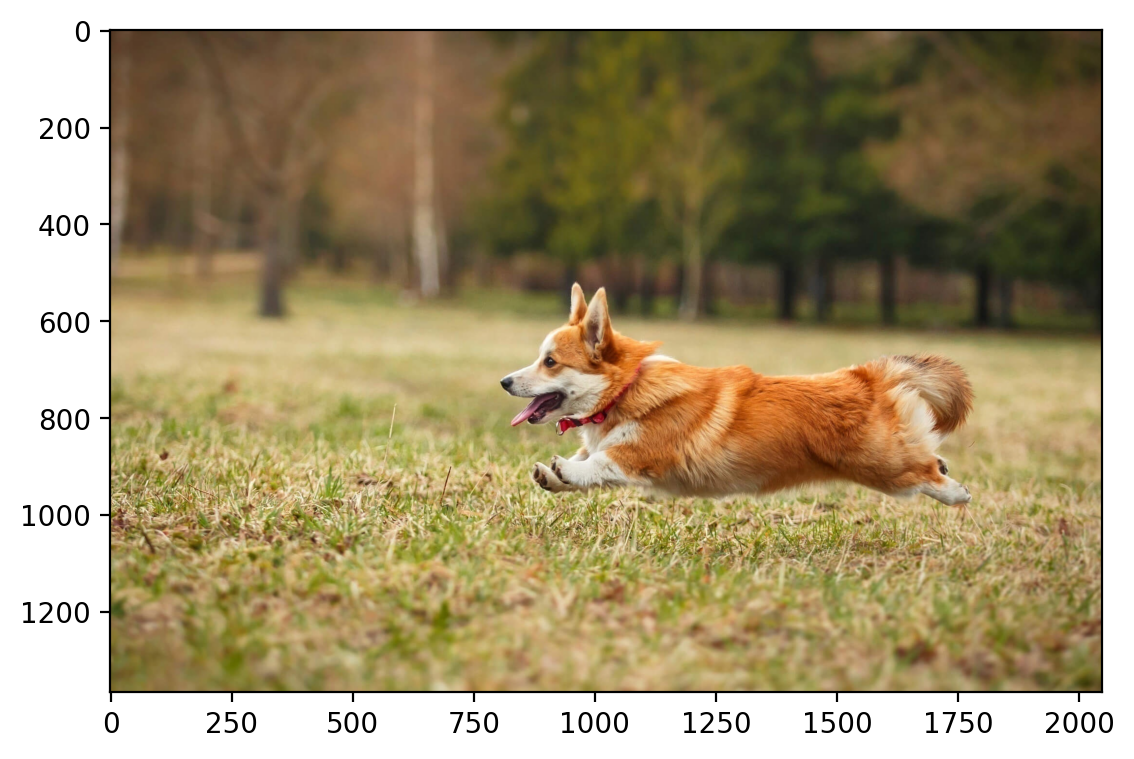

In [1]:
import cv2
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
from sklearn import preprocessing
import torch.nn as nn
import torch.nn.functional as F
# from google.colab.patches import cv2_imshow

import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange
img = cv2.imread('./dog.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
print(img.shape)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [2]:
# torch.cuda.current_device()

In [3]:
status = cv2.imwrite('./dog.jpg',img)
print("Image written to file-system : ",status)

Image written to file-system :  True


In [4]:
# read image
img = cv2.imread('./dog.jpg')
# get dimensions of image
dimensions = img.shape
# height, width, number of channels in image
height = img.shape[0]
width = img.shape[1]
channels = img.shape[2]
print('Image Dimension    : ',dimensions)
print('Image Height       : ',height)
print('Image Width        : ',width)
print('Number of Channels : ',channels)

Image Dimension    :  (1365, 2048, 3)
Image Height       :  1365
Image Width        :  2048
Number of Channels :  3


**Croping the picture to begin with 400*400 resolution image**

(1365, 2048, 3)
tensor([[[0.1451, 0.2000, 0.3098],
         [0.1490, 0.2039, 0.3137],
         [0.1490, 0.2039, 0.3137],
         ...,
         [0.1176, 0.2157, 0.2941],
         [0.1176, 0.2118, 0.2980],
         [0.1176, 0.2118, 0.2980]],

        [[0.1451, 0.2000, 0.3098],
         [0.1490, 0.2039, 0.3137],
         [0.1490, 0.2039, 0.3137],
         ...,
         [0.1176, 0.2157, 0.2941],
         [0.1176, 0.2118, 0.2980],
         [0.1176, 0.2118, 0.2980]],

        [[0.1451, 0.2000, 0.3098],
         [0.1490, 0.2039, 0.3137],
         [0.1412, 0.2078, 0.3137],
         ...,
         [0.1176, 0.2157, 0.2941],
         [0.1176, 0.2118, 0.2980],
         [0.1176, 0.2118, 0.2980]],

        ...,

        [[0.1451, 0.4039, 0.4745],
         [0.1451, 0.4039, 0.4745],
         [0.1412, 0.4118, 0.4784],
         ...,
         [0.1686, 0.3216, 0.3804],
         [0.1647, 0.3137, 0.3843],
         [0.1647, 0.3137, 0.3843]],

        [[0.1451, 0.4039, 0.4745],
         [0.1451, 0.4039, 0.474

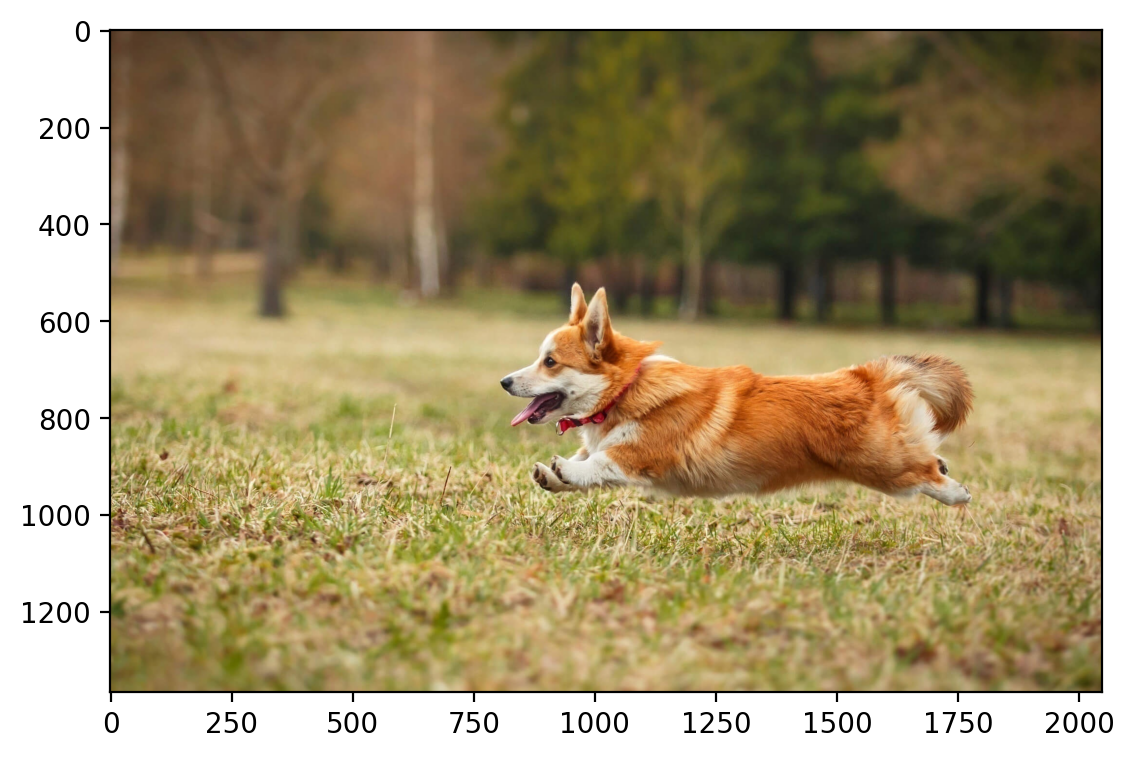

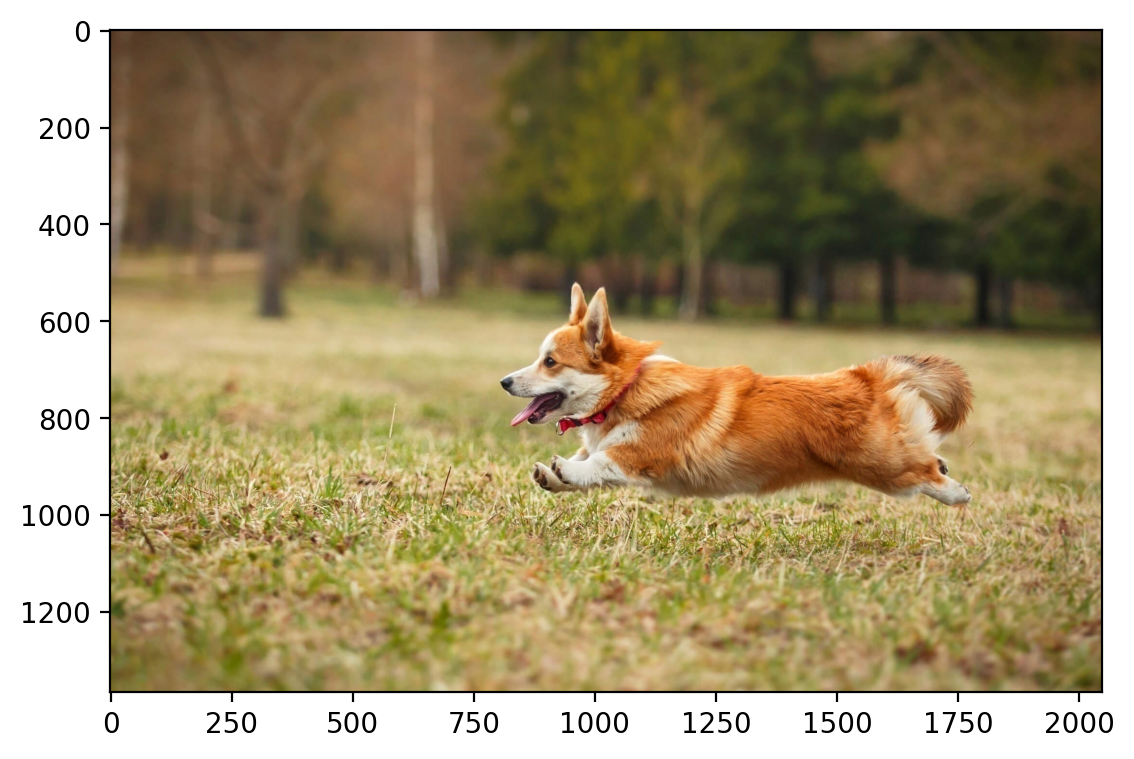

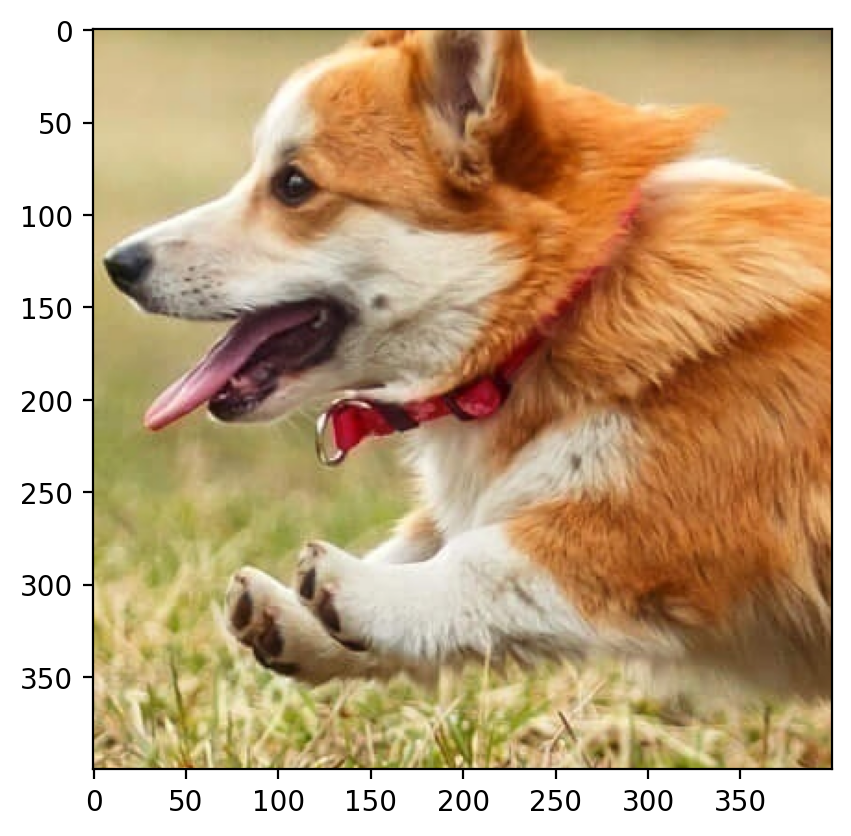

In [5]:
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
print(img_scaled.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
print(img_scaled)

# [rows, columns]
crop = img_scaled[600:1000, 800:1200]
print("Shape of the cropped image",crop.shape)

# Convert the tensor back to a NumPy array for display
img_scaled_np = img_scaled.cpu().numpy()

# Rescale pixel values back to [0, 255] for display with OpenCV
img_scaled_np = (img_scaled_np * 255).astype(np.uint8)
crop_np = (crop.cpu().numpy() * 255).astype(np.uint8)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_scaled_np, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(crop_np, cv2.COLOR_BGR2RGB))
plt.show()

**Cropping the image to get a 400*400 resolution image**

In [6]:
crop = crop.to(device)
# Get the dimensions of the image tensor
height, width,num_channels = crop.shape
print(num_channels, height, width)
del img

3 400 400


**Creating the coordinating map**

In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn import preprocessing
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import mean_squared_error
from math import log10, sqrt
from matplotlib import gridspec


# Create coordinate map function
def create_coordinate_map(img,scale=1):
    height, width,num_channels = img.shape
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'h w c -> (h w) c').float()
    return X, Y


dog_X, dog_Y = create_coordinate_map(crop)

print(dog_X.shape, dog_Y.shape)


torch.Size([160000, 2]) torch.Size([160000, 3])


**Scaling down and moving to gpu**

In [8]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()
print(dog_X_scaled)


tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9950],
        [-1.0000, -0.9900],
        ...,
        [ 1.0000,  0.9900],
        [ 1.0000,  0.9950],
        [ 1.0000,  1.0000]], device='cuda:0')


**Defining linear model and Training function**

In [9]:
# Linear Model definition
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


# Training function
def train(net, lr, X, Y, epochs, verbose=True):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()


**Defining plotting function**

In [10]:

def plot_reconstructed_and_original_image(original_img, predicted_img,X, scale=1,title=""):
    """
    Compare the original and predicted images.
    """
     # Move X to the device and convert to float32
    X = X.to(device).float()

    # Get the network's prediction
    outputs = net(X)

    # Reshape the output to have the correct number of channels
    outputs = rearrange(outputs.cpu().detach().numpy(), '(h w) c -> h w c', h=original_img.shape[0], w=original_img.shape[1])

    # Create a figure and axes
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(title, fontsize=16)

    # Plot the original image
    ax1.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    ax1.set_title("Original Image")

    # Plot the reconstructed (predicted) image
    ax0.imshow(cv2.cvtColor(outputs, cv2.COLOR_BGR2RGB)) # Changed from rearrange(outputs.cpu().numpy(),'h w c -> h w c')
    ax0.set_title("Reconstructed Image")

    plt.show()

    return outputs




**Creating RFF **

In [11]:

# Create Random Fourier Features
def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2),random_state = 100)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

# X_rff = create_rff_features(dog_X_scaled, 8000, 0.008)
# print(X_rff.shape)
# net = LinearModel(X_rff.shape[1], 3)
# net.to(device)

# train(net, 0.008, X_rff, dog_Y, 500)


**Resizing cropped 400*400 image to 200*200 image using OpenCV**

Resized Dimensions :  (200, 200, 3)


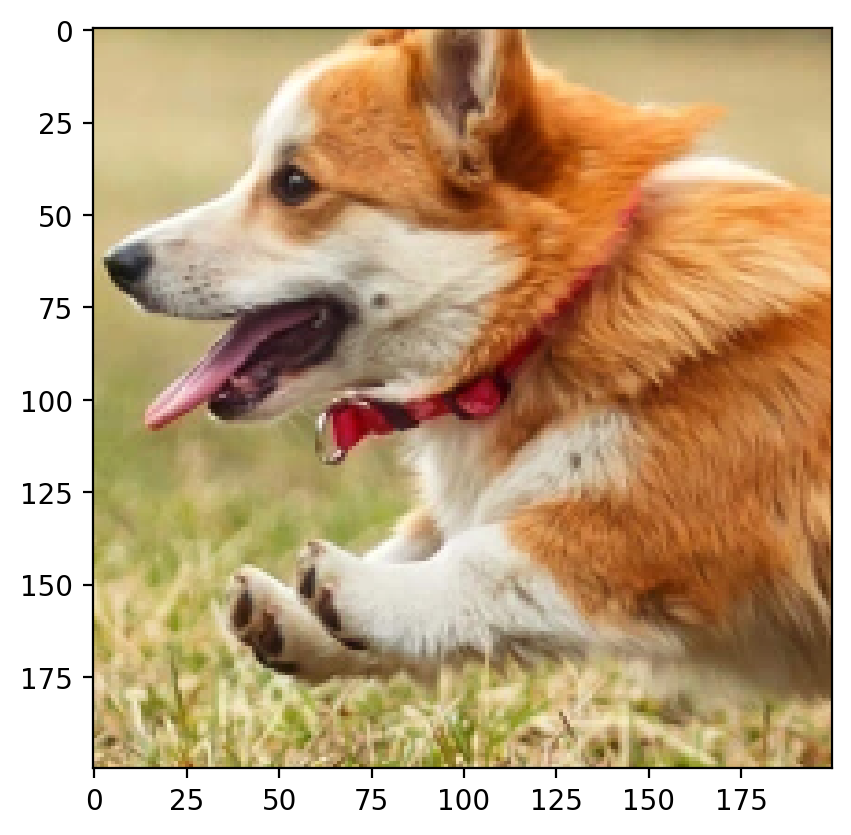

In [12]:

scale_percent = 50 # percent of original size
width = int(crop_np.shape[1] * scale_percent / 100)
height = int(crop_np.shape[0] * scale_percent / 100)
dim = (width, height)

# resize image
resized = cv2.resize(crop_np, dim, interpolation = cv2.INTER_AREA)

print('Resized Dimensions : ',resized.shape)

plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))

**Creating Coordinate map for the above image and scaling it.**

In [13]:
X_new, y_new = create_coordinate_map(crop, scale=1)
X_new.size(), y_new.size()

(torch.Size([160000, 2]), torch.Size([160000, 3]))

In [14]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X_new.cpu())

# Scale the X coordinates
X_new_scaled = scaler_X.transform(X_new.cpu())

# Move the scaled X coordinates to the GPU
X_new_scaled = torch.tensor(X_new_scaled).to(device)

# Set to dtype float32
X_new_scaled = X_new_scaled.float()
X_new_scaled

tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9950],
        [-1.0000, -0.9900],
        ...,
        [ 1.0000,  0.9900],
        [ 1.0000,  0.9950],
        [ 1.0000,  1.0000]], device='cuda:0')

In [15]:
# plt.imshow(cv2.cvtColor(, cv2.COLOR_BGR2RGB))
# crop.cpu().shape
crop = crop.cpu().numpy().astype(np.float32)

**Creating new RFF for this input image and predicting**

torch.Size([160000, 8000])
Epoch 0 loss: 0.366289
Epoch 100 loss: 0.025853
Epoch 200 loss: 0.016685
Epoch 300 loss: 0.014114
Epoch 400 loss: 0.012591


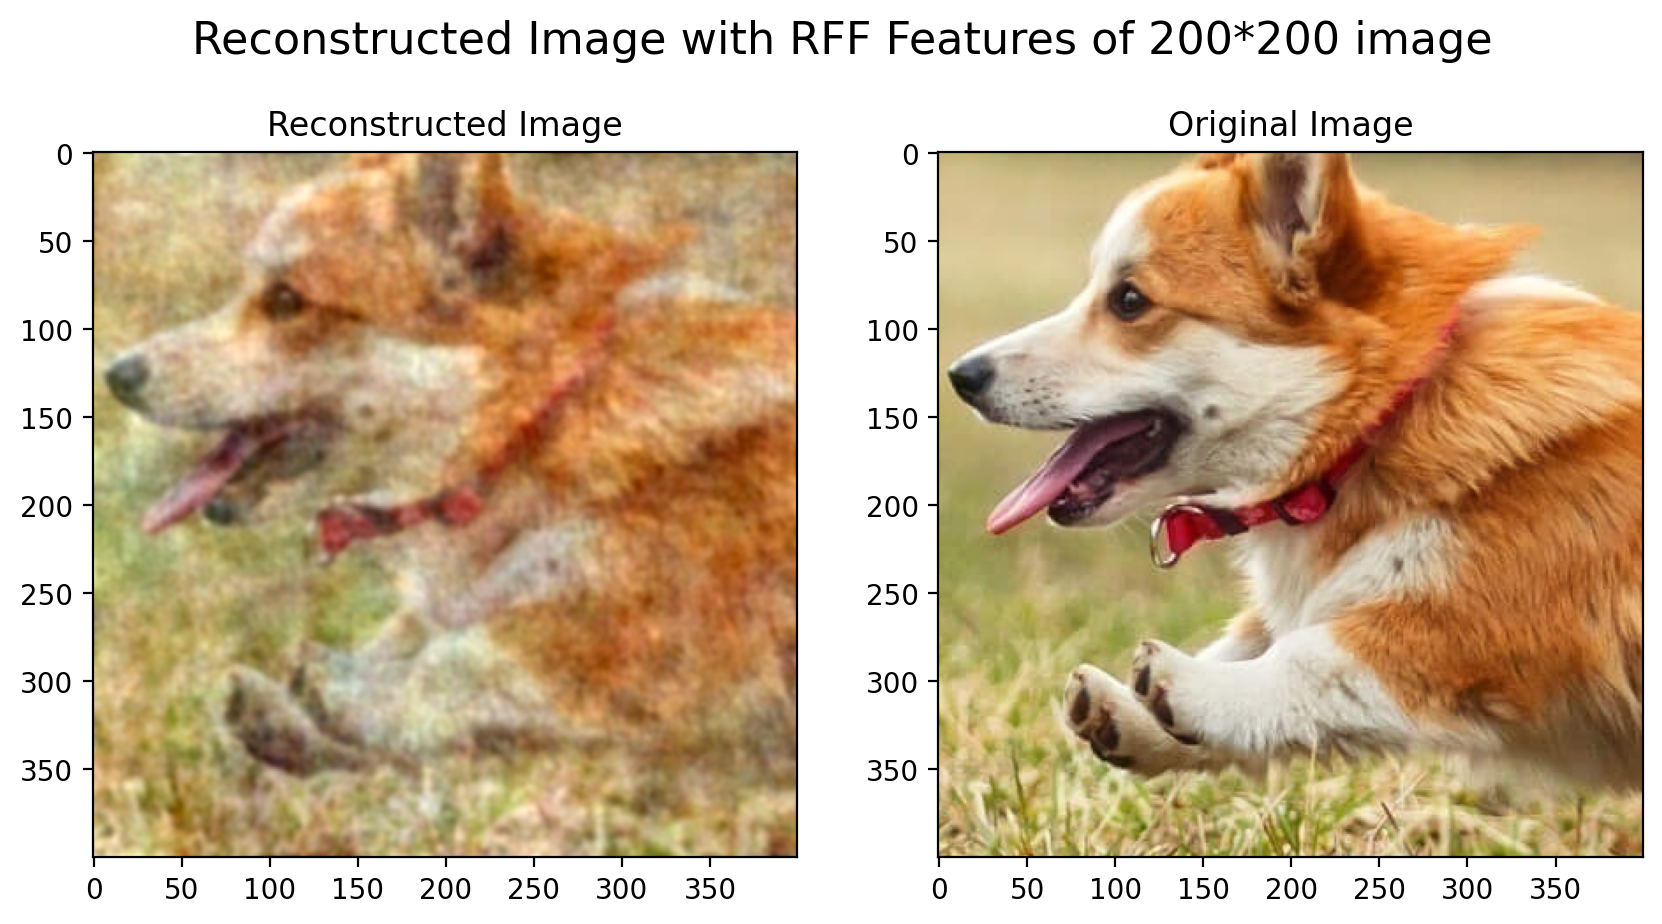

In [16]:
X_new_rff = create_rff_features(X_new_scaled, 8000, 0.008)
print(X_new_rff.shape)
net = LinearModel(X_new_rff.shape[1], 3)
net.to(device)
train(net, 0.008, X_new_rff, y_new, 500)
predicted_image = plot_reconstructed_and_original_image(crop, net, X_new_rff, scale = 1,title="Reconstructed Image with RFF Features of 200*200 image")
# predicted_image2 = plot_reconstructed_and_original_image(crop, net, X_rff, scale = 1,title="Reconstructed Image with RFF Features of 400*400 image")

In [19]:
print(crop.shape, predicted_image.dtype)
# print(crop.shape, predicted_image2.dtype)


(400, 400, 3) float32


**Calculating RMSE and PSNR**

In [20]:
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
rmse = np.sqrt(mean_squared_error(rearrange(crop, 'h w c -> h w c'), predicted_image))
print("RMSE1 =", rmse,"\n")
psnr = peak_signal_noise_ratio(rearrange(crop, 'h w c -> h w c'), predicted_image)
print("PSNR1 =", psnr,"\n")
# rmse = np.sqrt(mean_squared_error(rearrange(crop, 'h w c -> h w c'), predicted_image2))
# print("RMSE2 =", rmse,"\n")
# psnr = peak_signal_noise_ratio(rearrange(crop, 'h w c -> h w c'), predicted_image2)
# print("PSNR2 =", psnr,"\n")

RMSE1 = 0.1077445862474972 

PSNR1 = 19.35209084504407 

